Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [100]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

import os
from glob import glob

import warnings
warnings.filterwarnings('ignore')

In [63]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [64]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/home/sinhapiyush/Downloads/MS/Course_5/Module_4_Melanoma_Detection_Assignment/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/home/sinhapiyush/Downloads/MS/Course_5/Module_4_Melanoma_Detection_Assignment/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [65]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [66]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [67]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [68]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [69]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

Found 2239 files belonging to 9 classes.


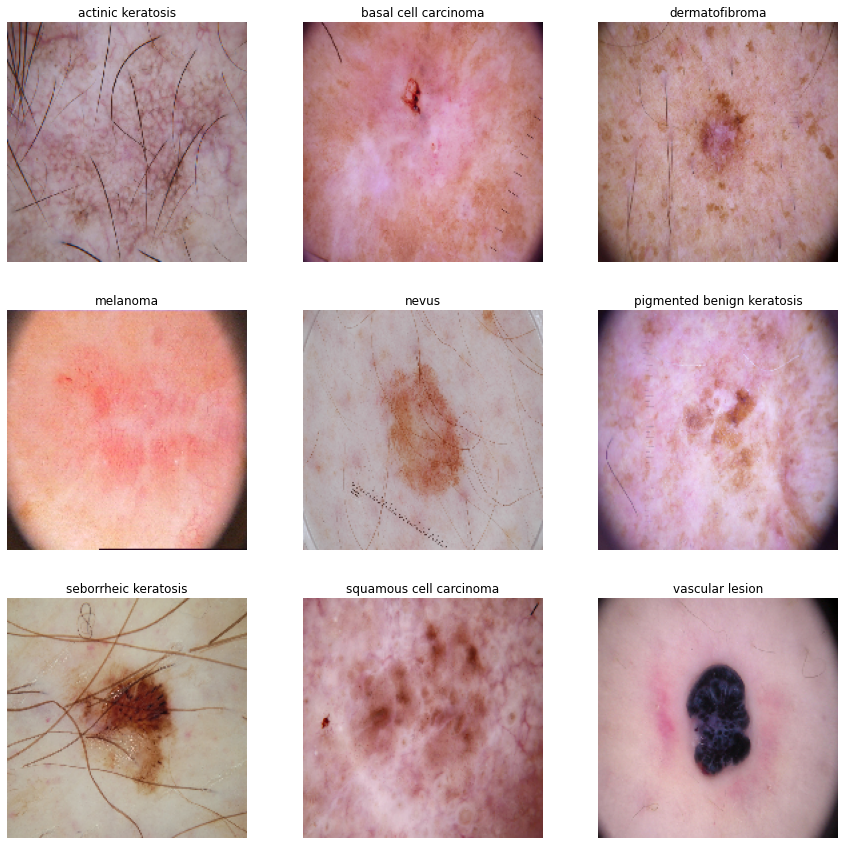

In [70]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.

image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [71]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [72]:
### Your code goes here
    
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [73]:
### Todo, choose an appropirate optimiser and loss function

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [74]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 41, 41, 128)      

### Train the model

In [75]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 2.0047 - accuracy: 0.2751
Epoch 1: val_accuracy improved from -inf to 0.25727, saving model to model.h5
56/56 [==============================] - 42s 687ms/step - loss: 2.0047 - accuracy: 0.2751 - val_loss: 2.0765 - val_accuracy: 0.2573
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.7005 - accuracy: 0.3884
Epoch 2: val_accuracy improved from 0.25727 to 0.48770, saving model to model.h5
56/56 [==============================] - 39s 703ms/step - loss: 1.7005 - accuracy: 0.3884 - val_loss: 1.5371 - val_accuracy: 0.4877
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.5427 - accuracy: 0.4548
Epoch 3: val_accuracy improved from 0.48770 to 0.51902, saving model to model.h5
56/56 [==============================] - 36s 648ms/step - loss: 1.5427 - accuracy: 0.4548 - val_loss: 1.4588 - val_accuracy: 0.5190
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 1.4693 - accur

### Visualizing training results

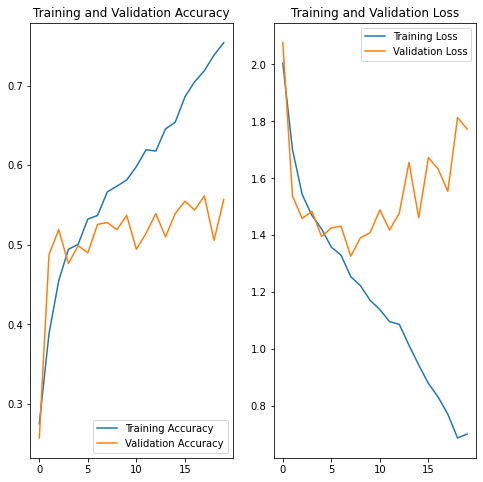

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

`In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 55% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable — a sign of overfitting.`

### Write your findings here

In [78]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

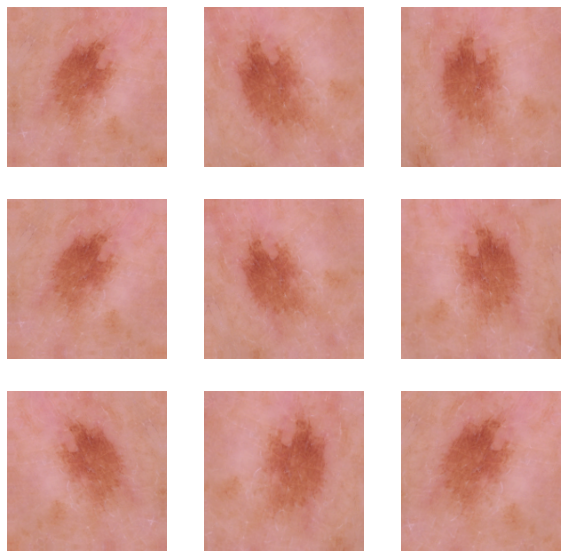

In [77]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [79]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

### Compiling the model

In [80]:
## Your code goes here

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

### Training the model

In [87]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 38s 681ms/step - loss: 1.1155 - accuracy: 0.6083 - val_loss: 1.5374 - val_accuracy: 0.5280
Epoch 2/20
56/56 [==============================] - 37s 663ms/step - loss: 1.0490 - accuracy: 0.6295 - val_loss: 1.4686 - val_accuracy: 0.5526
Epoch 3/20
56/56 [==============================] - 37s 664ms/step - loss: 0.9626 - accuracy: 0.6585 - val_loss: 1.4195 - val_accuracy: 0.5503
Epoch 4/20
56/56 [==============================] - 36s 646ms/step - loss: 0.9090 - accuracy: 0.6702 - val_loss: 1.5300 - val_accuracy: 0.5414
Epoch 5/20
56/56 [==============================] - 38s 687ms/step - loss: 0.8914 - accuracy: 0.6858 - val_loss: 1.8291 - val_accuracy: 0.5034
Epoch 6/20
56/56 [==============================] - 38s 675ms/step - loss: 0.8107 - accuracy: 0.7121 - val_loss: 1.6558 - val_accuracy: 0.5526
Epoch 7/20
56/56 [==============================] - 38s 677ms/step - loss: 0.7615 - accuracy: 0.7254 - val_loss: 1.7261 - val_accuracy: 0.5436

### Visualizing the results

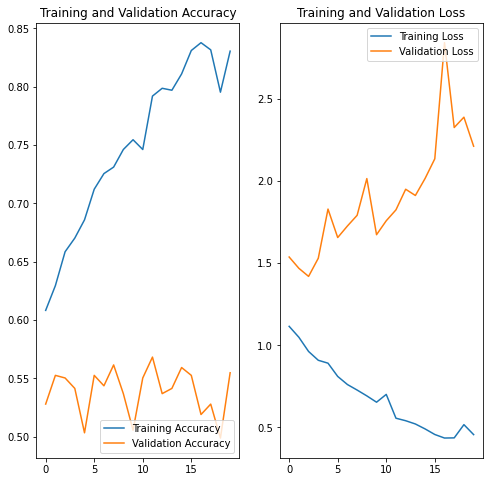

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

` Better augmentation technique is required to improve the model`

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [89]:
## Your code goes here.
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,pigmented benign keratosis,462
2,vascular lesion,139
3,squamous cell carcinoma,181
4,seborrheic keratosis,77
5,dermatofibroma,95
6,basal cell carcinoma,376
7,nevus,357
8,melanoma,438


<AxesSubplot:xlabel='No. of Image', ylabel='Class'>

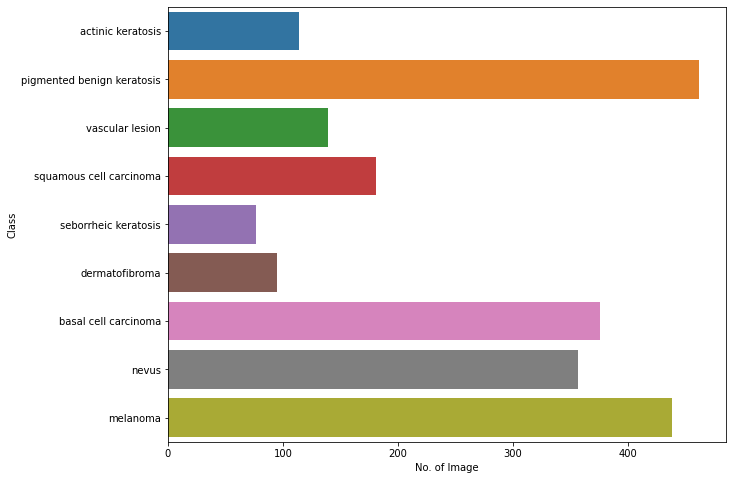

In [90]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
`seborrheic keratosis`
#### - Which classes dominate the data in terms proportionate number of samples?
`pigmented benign keratosis`

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [91]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [93]:
path_to_training_dataset="/home/sinhapiyush/Downloads/MS/Course_5/Module_4_Melanoma_Detection_Assignment/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /home/sinhapiyush/Downloads/MS/Course_5/Module_4_Melanoma_Detection_Assignment/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0B69774370>: 100%


Initialised with 376 image(s) found.
Output directory set to /home/sinhapiyush/Downloads/MS/Course_5/Module_4_Melanoma_Detection_Assignment/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0B69152B30>: 100%


Initialised with 95 image(s) found.
Output directory set to /home/sinhapiyush/Downloads/MS/Course_5/Module_4_Melanoma_Detection_Assignment/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0B691010C0>: 100%


Initialised with 438 image(s) found.
Output directory set to /home/sinhapiyush/Downloads/MS/Course_5/Module_4_Melanoma_Detection_Assignment/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0B69194B50>: 100


Initialised with 357 image(s) found.
Output directory set to /home/sinhapiyush/Downloads/MS/Course_5/Module_4_Melanoma_Detection_Assignment/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2012x1956 at 0x7F0B695173A0>: 10


Initialised with 462 image(s) found.
Output directory set to /home/sinhapiyush/Downloads/MS/Course_5/Module_4_Melanoma_Detection_Assignment/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0B4A817BB0>: 100%


Initialised with 77 image(s) found.
Output directory set to /home/sinhapiyush/Downloads/MS/Course_5/Module_4_Melanoma_Detection_Assignment/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x


Initialised with 181 image(s) found.
Output directory set to /home/sinhapiyush/Downloads/MS/Course_5/Module_4_Melanoma_Detection_Assignment/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7


Initialised with 139 image(s) found.
Output directory set to /home/sinhapiyush/Downloads/MS/Course_5/Module_4_Melanoma_Detection_Assignment/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0B215C95D0>: 100%


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [94]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [101]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
path_list

['/home/sinhapiyush/Downloads/MS/Course_5/Module_4_Melanoma_Detection_Assignment/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030133.jpg_107d7aec-0750-4279-9e74-15b5051e1770.jpg',
 '/home/sinhapiyush/Downloads/MS/Course_5/Module_4_Melanoma_Detection_Assignment/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028558.jpg_eb4b0e06-0002-4d27-874d-6b875c0aa828.jpg',
 '/home/sinhapiyush/Downloads/MS/Course_5/Module_4_Melanoma_Detection_Assignment/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029713.jpg_d74bc3b8-da4b-42eb-8aa2-3c15495e825e.jpg',
 '/home/sinhapiyush/Downloads/MS/Course_5/Module_4_Melanoma_Detection_Assignment/M

In [102]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [104]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [106]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df.append(df2)

In [117]:
new_df['Label'].value_counts()

actinic keratosis             500
pigmented benign keratosis    500
vascular lesion               500
squamous cell carcinoma       500
seborrheic keratosis          500
dermatofibroma                500
basal cell carcinoma          500
nevus                         500
melanoma                      500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [108]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [120]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [121]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [122]:
## your code goes here

#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 41, 41, 128)     

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [123]:
## your code goes here

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

#### **Todo:**  Train your model

In [124]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint])

Epoch 1/30
169/169 [==============================] - ETA: 0s - loss: 2.1134 - accuracy: 0.1975
Epoch 1: val_accuracy improved from -inf to 0.39347, saving model to model.h5
169/169 [==============================] - 125s 732ms/step - loss: 2.1134 - accuracy: 0.1975 - val_loss: 1.6828 - val_accuracy: 0.3935
Epoch 2/30
169/169 [==============================] - ETA: 0s - loss: 1.5887 - accuracy: 0.3935
Epoch 2: val_accuracy improved from 0.39347 to 0.44692, saving model to model.h5
169/169 [==============================] - 118s 699ms/step - loss: 1.5887 - accuracy: 0.3935 - val_loss: 1.4910 - val_accuracy: 0.4469
Epoch 3/30
169/169 [==============================] - ETA: 0s - loss: 1.4305 - accuracy: 0.4540
Epoch 3: val_accuracy improved from 0.44692 to 0.49443, saving model to model.h5
169/169 [==============================] - 120s 711ms/step - loss: 1.4305 - accuracy: 0.4540 - val_loss: 1.3164 - val_accuracy: 0.4944
Epoch 4/30
169/169 [==============================] - ETA: 0s - los

169/169 [==============================] - ETA: 0s - loss: 0.2771 - accuracy: 0.8954
Epoch 28: val_accuracy improved from 0.84261 to 0.84558, saving model to model.h5
169/169 [==============================] - 124s 730ms/step - loss: 0.2771 - accuracy: 0.8954 - val_loss: 0.7038 - val_accuracy: 0.8456
Epoch 29/30
169/169 [==============================] - ETA: 0s - loss: 0.2880 - accuracy: 0.8935
Epoch 29: val_accuracy did not improve from 0.84558
169/169 [==============================] - 121s 715ms/step - loss: 0.2880 - accuracy: 0.8935 - val_loss: 0.8669 - val_accuracy: 0.8033
Epoch 30/30
169/169 [==============================] - ETA: 0s - loss: 0.2629 - accuracy: 0.9000
Epoch 30: val_accuracy did not improve from 0.84558
169/169 [==============================] - 131s 772ms/step - loss: 0.2629 - accuracy: 0.9000 - val_loss: 0.8254 - val_accuracy: 0.8241


#### **Todo:**  Visualize the model results

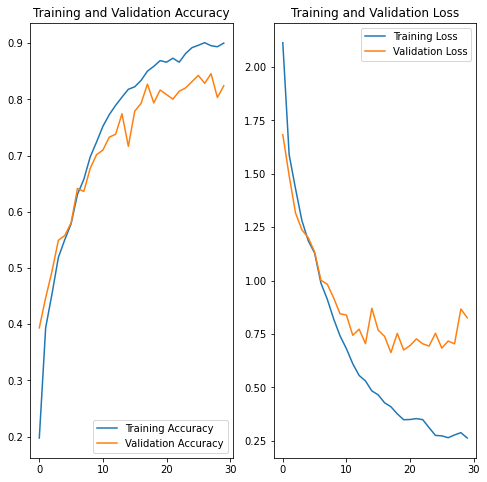

In [125]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Prediction

1/1 [==============================] - 0s 19ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


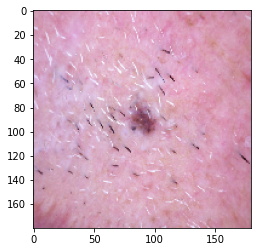

In [130]:
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-3],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



`Our model is able to predict the classes with much better accuracy. The class rebalance helped our model to reduce the overfitting as the difference between training accuracy (~89.5%) and validation accuracy (~84.5%) for the best model is comparitively less.`